### Import and install

In [1]:
import nltk
import string
import copy
import re
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
nltk.download('words')

[nltk_data] Downloading package words to /Users/jackcook/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### Get 5 letter words

Downloaded from https://www.powerlanguage.co.uk/wordle/main.e65ce0a5.js, the former (shorter) array of ~2,500 is [apparently the list of possible answers](https://puzzling.stackexchange.com/questions/114419/what-dictionary-is-wordle-based-on), whereas there are ~10,000 other valid guesses.

For our use case, we only care about answers as potential words.

In [2]:
with open('answers.txt') as file:
    possible_answers = file.readlines()

list_possible_answers = sorted([re.sub(r'[^A-Z]', '', t.upper()) for t in possible_answers[0].split(',')])
print(len(list_possible_answers),
      list_possible_answers[:5])

2315 ['ABACK', 'ABASE', 'ABATE', 'ABBEY', 'ABBOT']


Arrange as a DataFrame

In [3]:
arr_words_5l = np.array([list(w) for w in list_possible_answers])
df_words_5l = pd.DataFrame(data=arr_words_5l,
                           columns=[f'letter_{i+1}' for i in range(5)])
df_words_5l['word'] = list_possible_answers
df_words_5l.head()

,letter_1,letter_2,letter_3,letter_4,letter_5,word
0,A,B,A,C,K,ABACK
1,A,B,A,S,E,ABASE
2,A,B,A,T,E,ABATE
3,A,B,B,E,Y,ABBEY
4,A,B,B,O,T,ABBOT


Assess how frequent letters are at each position

In [4]:
test_dict_letter_counts = Counter()
for i in range(5):
    test_dict_letter_counts[i+1] = Counter(df_words_5l[f'letter_{i+1}'])
    
test_dict_letter_counts[1]

Counter({'A': 141,
         'B': 173,
         'C': 198,
         'D': 111,
         'E': 72,
         'F': 136,
         'G': 115,
         'H': 69,
         'I': 34,
         'J': 20,
         'K': 20,
         'L': 88,
         'M': 107,
         'N': 37,
         'O': 41,
         'P': 142,
         'Q': 23,
         'R': 105,
         'S': 366,
         'T': 149,
         'U': 33,
         'V': 43,
         'W': 83,
         'Y': 6,
         'Z': 3})

Initialise game

In [5]:
class Game:
    
    def __init__(self, df_all_5l_words):
        
        # Start with whole alphabet as list of possible letters in word
        self.possible_letters = list(string.ascii_uppercase)
        
        # To store guessed letters that are correct, but in the wrong location
        self.dict_misplaced_letters = Counter()
        
        # Possible answers
        self.df_possible_5l_words = df_all_5l_words.copy(deep=True)
        
        # Dictionary of answers, initialised as empty
        self.dict_letters = defaultdict(str)
        for i in range(5):
            self.dict_letters[i+1] = None
        
        # Initialise dictionary of letter counts at each position, updated as we play the game
        self.dict_letter_counts = defaultdict(str)
        for i in range(5):
            self.dict_letter_counts[i+1] = Counter(df_all_5l_words[f'letter_{i+1}'])
        

    def calculate_freq_score(self, letters: str) -> int:
        '''
        Based on a set of letters, sum their frequency score at each position.
        e.g. If we have 1,000 possible 5 letter words, and we look at the word
        STAGE - if S appears as the first letter of 300 words in the 1,000, then
        S gets a score of 300.
        
        Applying this logic to all letters in the word provides a frequency score,
        with the idea that a high word score implies that the word contains frequently
        occurring letters (relative to the possible 5 letter words) - and is therefore a 
        good word for our next guess.
        
        :param letters: 5 character string, case insensitive
        :returns: a frequency score (int) for the word as defined above.
        '''
        
        letters = re.sub('^A-Z', '', letters.upper())
        assert len(letters) == 5, 'Word must be 5 characters long'
        score = 0
        for i, l in enumerate(list(letters.upper())):
            score += self.dict_letter_counts[i+1][l]
            
        return score
        
    
    def guess(self):
        '''
        Given a game state, returns a dataframe of possible 5 letter words (through self.df_possible_5l_words)
        ordered by the highest frequency score descending. Frequency score is calculated using 
        the self.calculate_freq_score() method, vectorized for performance.
        
        :returns: self.df_possible_5l_words, ordered by freq_score descenging
        '''
        
        # First, reset letter counts
        for i in range(5):
            self.dict_letter_counts[i+1] = Counter(self.df_possible_5l_words[f'letter_{i+1}'])
        
        # Vectorize frequency score function to make it run faster
        vect_calculate_freq_score = np.vectorize(self.calculate_freq_score)
        
        self.df_possible_5l_words['freq_score'] = vect_calculate_freq_score(self.df_possible_5l_words['word'])
        
        self.df_possible_5l_words = self.df_possible_5l_words.sort_values(by='freq_score', ascending=False)
        return self.df_possible_5l_words
    
    
    def check_misplaced_letters(self, word: str) -> bool:
        '''
        Allows us to filter dataframe of possible words containing at least the misplaced letters.
        
        e.g. If I guess 'GREET', and the 3rd  E is green, I filter the dataframe of possible words
        for position 3 == "E". But if the 4th E is yellow, I also want to filter the possible words for 
        any where E falls in the 1st, 2nd, or 5th spots.
        
        We would first filter for position 4 != "E" (done in the self.update() method), then for a given word - 
        check that the count of the letter "E" was >=1 outside of position 3.
        
        :param word: 5 character string, case insensitive
        :returns: a boolean, where True implies that the word has AT LEAST the letters contained in 
        self.dict_misplaced_letters (e.g. 2 "E"s outside of position 3 in the above example would be acceptable).
        '''
        
        word = re.sub(r'[^A-Z]', '', word.upper())
        assert len(word) == 5, 'Word must be 5 characters long'
        
        # Break into letters
        list_word = list(word)
        
        # Get indices (1 indexed) of positions that have not yet been solved
        not_solved = [key for key, value in self.dict_letters.items() if value is None]
        
        # Filter list of words for those not yet solved, removing 1 from the index as our letters are 1 indexed
        list_word_unsolved = [list_word[i-1] for i in not_solved]
        
        # Check counts
        dict_count_letters = Counter(list_word_unsolved)
        
        # Compare to dictionary of misplaced letters
        valid = True
        for check_key, check_value in self.dict_misplaced_letters.items():
            if dict_count_letters[check_key] < check_value:
                valid = False
                
        return valid
        
    
    def update(self, guess: str, results: list):
        '''
        Takes a 5 letter guess as a string, and a list of results in the format:
        0 - incorrect
        1 - right letter, wrong place (known as misplaced)
        2 - right letter, right place (known as correct)
        
        Updates the game states:
        - self.df_possible_5l_words: list of possible 5 letter word answers
        - self.dict_misplaced_letters: Counter dictionary of misplaced letters, and how many there 
          are in the target word.
        - self.dict_letters: dictionary of the correct letter at each position (starts out with NULL values)
        - self.possible_letters: letters of the alphabet that we can still use for guesses
        
        Doesn't return anything.
        
        :param guess: 5 character string, case insensitive
        :param results: 5 item list containing only ints of the values 0, 1, or 2 indicating whether the guess
        was correct (2), misplaced (1), or incorrect(0) at each corresponding position
        '''
        
        guess = re.sub(r'[^A-Z]', '', guess.upper())
        assert len(guess) == 5, 'Guess must be 5 characters long'
        assert len(results) == 5, 'Results list must contain 5 items'
        assert all([n in [0,1,2] for n in results]), 'Results list must only contain ints 0, 1, or 2'
        
        # Convert guess into list of letters
        list_guess = list(guess.upper())
        
        # Zip with results
        df_guess_results = pd.DataFrame(data=list(zip(list_guess, results)),
                                        columns=['letter', 'result'],
                                        index=np.arange(1,6))
        
        # To prevent iterating through already solved letters
        already_solved = [key for key, value in self.dict_letters.items() if value is not None]
        

        # Update correct answers
        df_corr_answers = df_guess_results.query('result==2')
        if df_corr_answers.shape[0] > 0:
            for idx, row in df_corr_answers.iterrows():
                
                # Prevent updates for previously solved letters
                if idx in already_solved:
                    pass
                else:
                    corr_letter = row['letter']
                    self.dict_letters[idx] = corr_letter
                
                    # If correct letter was previously guessed as a misplaced letter, remove it
                    if corr_letter in self.dict_misplaced_letters.keys():
                        self.dict_misplaced_letters[corr_letter] -= 1
                        
                    # And filter dataframe of possible words
                    self.df_possible_5l_words = self.df_possible_5l_words.query(f'letter_{idx}=="{corr_letter}"')

          
        # Add misplaced letters to our list, if it's a new letter
        df_mispl_answers = df_guess_results.query('result==1')
        if df_mispl_answers.shape[0] > 0:
            
            # Filter dataframe to remove any words that have the misplaced letter in that column
            for idx, row in df_mispl_answers.iterrows():
                mispl_letter = row['letter']
                self.df_possible_5l_words = self.df_possible_5l_words.query(f'letter_{idx}!="{mispl_letter}"')  
            
            # Check how many we have of each letter that's misplaced
            guess_mispl_letters = df_mispl_answers['letter'].values
            dict_guess_mispl_letters = Counter(guess_mispl_letters)
            
            # Then update our dictionary of misplaced letters
            for key, value in dict_guess_mispl_letters.items():
                self.dict_misplaced_letters[key] = value   
            
            # Filter dataframe for words containing at least the count of the misplaced letters
            vect_check_misplaced_letters = np.vectorize(self.check_misplaced_letters)
            self.df_possible_5l_words['valid'] = vect_check_misplaced_letters(self.df_possible_5l_words['word'])
            self.df_possible_5l_words = self.df_possible_5l_words.query('valid == True')
            self.df_possible_5l_words = self.df_possible_5l_words.drop('valid', axis=1)    
        
        
        # Remove any incorrect letters from the list to guess from, if letter isn't in misplaced list
        df_wrong_answers = df_guess_results.query('result==0')
        if df_wrong_answers.shape[0] > 0:
            
            # Ensure we don't double count
            for l in df_wrong_answers['letter'].unique():
                if self.dict_misplaced_letters[l] == 0:
                    self.possible_letters.remove(l)
                
                
        # Finally, update list of possible 5 letter words by removing all rows where
        # for letters yet to be guessed, they don't fall in the list of possible letters
        yet_to_solve = [key for key, value in self.dict_letters.items() if value is None]
        for position in yet_to_solve:
            
            # Check all letters in a given position
            position_letters = self.df_possible_5l_words[f'letter_{position}']
            
            # Return a boolean list of whether that list is in the possible values or not
            position_in_possible_letters = [l in self.possible_letters for l in position_letters]
            
            # Filter
            self.df_possible_5l_words = self.df_possible_5l_words[position_in_possible_letters].copy(deep=True)
    
        
MyGame = Game(df_words_5l)

Create a test function to play the game, given a target word to find

In [6]:
df_words_5l.columns

Index(['letter_1', 'letter_2', 'letter_3', 'letter_4', 'letter_5', 'word'], dtype='object')

In [12]:
def play_game(target_word, df_possible_words, debug=False):
    '''
    Allows us to play a game of wordle automatically by providing a target word.
    
    Runs through 6 guesses by:
    - Initialising an instance of Game
    - Running Game().guess() and taking the first row of the resulting dataframe as the
      guess (word with the highest frequency score)
    - Checking which letters, if any, in the guess match the target_word correctly (in the same positions)
    - Checking whether any of the remaining letters in the guess appear in the target word (misplaced letters),
      otherwise tagging them as incorrect
    - Generating a result list of length 5 with values of 0 (incorrect), 1 (misplaced), or 2 (correct)
    - If the list contains all 2's (correct guess), breaking the loop
    - Otherwise, passes the guess and the result list to Game().update() to start the next guess loop
    
    This can be run with debug mode on or off, if debug mode is set to:
    - True: It will print the summary of the guess & results at each turn, and when the game is finished or unsolved
    - False: It will return a tuple of (target_word, guess_turn+1) when either the game is finished or unsolved, 
      useful for running lots of examples and tracking the results.

    :param target_word: 5 character string that must be a part of this list https://github.com/jack-cook-repo/wordle-solver/blob/main/answers.txt
    :param df_possible_words: A dataframe with the following columns ['letter_1', 'letter_2', 'letter_3', 'letter_4', 'letter_5', 'word']
    :returns: If debug=False, a tuple of (target_word, guess_turn+1), where guess_turn+1 is either the turn
    when the word was guessed correctly (adding 1 to handle 0 indexing), or 7 if the word wasn't guessed after 6 tries
    '''
    
    target_word = re.sub(r'[^A-Z]', '', target_word.upper())
    assert len(target_word) == 5, 'target_word must be 5 characters long'
    assert all(df_possible_words.columns == ['letter_1', 'letter_2', 'letter_3', 'letter_4', 'letter_5', 'word']), "Dataframe must have columns ['letter_1', 'letter_2', 'letter_3', 'letter_4', 'letter_5', 'word']"
    
    TestGame = Game(df_possible_words)
    
    target_letters = list(target_word)
    
    for guess_turn in range(6):
        
        # Return word with highest frequency count across all letters as the guess
        guess_word = TestGame.guess().iloc[0]['word'] 
        guess_letters = list(guess_word)
        
        # Dictionary of results at each position
        dict_results = defaultdict(str)
        for i in range(5):
            dict_results[i] = None
        
        # First assign correct letters with a score of 2
        for pos, guess_letter in enumerate(guess_letters):
            if guess_letter == target_letters[pos]:
                dict_results[pos] = 2
        
        # For remaining letters, if they appear within the target word - count them as misplaced
        # Otherwise, count them as wrong
        remaining_pos = [key for key, value in dict_results.items() if value is None]
        if len(remaining_pos) == 0:
            # Guess correct
            results = [2, 2, 2, 2, 2]
        else:
            # Tag remaining letters in our guess and their position
            # Need to use list as we may have duplicate keys (same letter in >1 position)
            remaining_guess_letters = [[guess_letters[i], i] for i in remaining_pos]
            
            # Tag remaining letters in the answer, and create a Counter dictionary
            remaining_target_letters = [target_letters[i] for i in remaining_pos]
            dict_target_letter_count = Counter(remaining_target_letters)
            
            # Loop through our remaining guess letters
            for [letter, pos] in remaining_guess_letters:
                # Check they appear in the target word at least once
                if dict_target_letter_count[letter] > 0:
                    
                    # Subtract from target letter count, to prevent double counting
                    # e.g. tag first 'E' as misplaced, second 'E' as wrong when guessing GREET for
                    # target word STAGE
                    dict_target_letter_count[letter] -= 1
                    
                    # Update results
                    dict_results[pos] = 1
                else:
                    dict_results[pos] = 0
             
            # Turn into list 
            results = list(dict_results.values())
            
        # Finally, produce results as a list and pass back to game to update
        if debug:
            print(f'Turn {guess_turn+1}, guess {guess_word}, results {results}\n')
        if np.sum(results) == 10:
            if debug:
                print('Game won!')
            else:
                # Used for tracking metrics
                return (target_word, guess_turn+1)
            break
            
        # If the game isn't solved by turn 6, return "7" as the number of guesses
        if guess_turn == 5:
            if debug:
                print('Unsolved!')
            else:
                # Used for tracking metrics
                return (target_word, 7)
        
        TestGame.update(guess_word, results)

Test with a random sample of answers

In [14]:
rand_keys = np.random.randint(low=0, high=len(list_possible_answers), size=5)
rand_words = [list_possible_answers[k] for k in rand_keys]

for i, word in enumerate(rand_words):
    print(f'**GAME {i}: target {word}**')
    play_game(word, df_words_5l, debug=True)
    print('\n')

**GAME 0: target CLASP**
Turn 1, guess SLATE, results [1, 2, 2, 0, 0]

Turn 2, guess CLASH, results [2, 2, 2, 2, 0]

Turn 3, guess CLASS, results [2, 2, 2, 2, 0]

Turn 4, guess CLASP, results [2, 2, 2, 2, 2]

Game won!


**GAME 1: target MISSY**
Turn 1, guess SLATE, results [1, 0, 0, 0, 0]

Turn 2, guess MISSY, results [2, 2, 2, 2, 2]

Game won!


**GAME 2: target BELLY**
Turn 1, guess SLATE, results [0, 1, 0, 0, 1]

Turn 2, guess LEVEL, results [1, 2, 0, 0, 1]

Turn 3, guess BELLY, results [2, 2, 2, 2, 2]

Game won!


**GAME 3: target DITTY**
Turn 1, guess SLATE, results [0, 0, 0, 2, 0]

Turn 2, guess MIRTH, results [0, 2, 0, 2, 0]

Turn 3, guess DITTY, results [2, 2, 2, 2, 2]

Game won!


**GAME 4: target FILER**
Turn 1, guess SLATE, results [0, 1, 0, 0, 1]

Turn 2, guess LEVEL, results [1, 0, 0, 2, 0]

Turn 3, guess BOWEL, results [0, 0, 0, 2, 1]

Turn 4, guess FILER, results [2, 2, 2, 2, 2]

Game won!




Test across all answers, returning results

In [16]:
all_results = []
for answer in tqdm(list_possible_answers):
    all_results.append(play_game(answer, df_words_5l, debug=False))
all_results[:10]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2315/2315 [02:07<00:00, 18.13it/s]


[('ABACK', 5),
 ('ABASE', 4),
 ('ABATE', 3),
 ('ABBEY', 4),
 ('ABBOT', 4),
 ('ABHOR', 4),
 ('ABIDE', 4),
 ('ABLED', 4),
 ('ABODE', 3),
 ('ABORT', 4)]

Convert to dataframe, and plot our results!

In [17]:
df_all_results = pd.DataFrame(data=all_results,
                              columns=['word', 'turns_taken'])
print(df_all_results['turns_taken'].mean())
df_all_results['turns_taken'].value_counts()

3.673866090712743


4    990
3    854
5    267
2    146
6     44
7     13
1      1
Name: turns_taken, dtype: int64

<AxesSubplot:xlabel='turns_taken', ylabel='Count'>

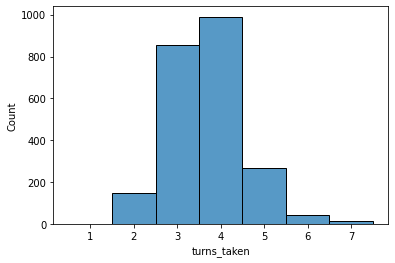

In [18]:
sns.histplot(data=df_all_results['turns_taken'],
             discrete=True)